# 1. Imports

In [206]:
import numpy as np
from math import pi
import matplotlib.pyplot as plt
from copy import deepcopy

In [2]:
from tensorflow.keras.models import load_model

In [3]:
from tensorflow.keras.losses import MSE
from tensorflow.keras.losses import categorical_crossentropy as CCE
import tensorflow as tf

In [4]:
# Load properties from another python file
from properties import *

In [5]:
from random import random, randint

In [6]:
path_model = "ACAS_XU_tf_keras/ACASXU_1_1.h5"

# 2. Load models

In [7]:
model_11 = load_model(path_model)

In [8]:
model_35 = load_model("ACAS_XU_tf_keras/ACASXU_3_5.h5")

In [9]:
model_11.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_98 (Dense)             (None, 50)                300       
_________________________________________________________________
activation_98 (Activation)   (None, 50)                0         
_________________________________________________________________
dense_99 (Dense)             (None, 50)                2550      
_________________________________________________________________
activation_99 (Activation)   (None, 50)                0         
_________________________________________________________________
dense_100 (Dense)            (None, 50)                2550      
_________________________________________________________________
activation_100 (Activation)  (None, 50)                0         
_________________________________________________________________
dense_101 (Dense)            (None, 50)              

In [10]:
model_11.compile()

In [11]:
model_35.compile()

In [12]:
pt = np.array([1.0, 1.0, 1.0, 1.0, 1.0]).reshape(1,5)
model_11.predict(pt)

array([[0.19883643, 0.20087564, 0.19964513, 0.20093843, 0.19970441]],
      dtype=float32)

In [13]:
pt = np.array([1.0, 1.0, 1.0, 1.0, 1.0]).reshape(1,5)
model_35.predict(pt)

array([[0.1967246 , 0.2045978 , 0.19686562, 0.20457308, 0.19723897]],
      dtype=float32)

# 3. FGSM

In [ ]:
def generate_adv_sample(model, x0, label, loss_function="MSE", eps=1e-5):
    # transforming into a tensorflow object
    x0_ = tf.cast(x0, tf.float32)
    
    # record our gradients
    with tf.GradientTape() as tape:
        # explicitly indicate that our input should be tacked for gradient updates
        tape.watch(x0_)

        # use our model to make predictions on the input and then compute the loss
        pred = model(x0_)
        if loss_function == "CCE":
            np_label = np.array([i==label for i in range(0,5)]).reshape((1,5))
            loss = CCE(np_label, pred)
        elif loss_function == "MSE":
            loss = MSE(label, pred)
        else:
            raise Exception("Unknown loss function '{0}'".format(loss_function))
        
        # calculate the gradients of loss with respect to the input, then compute the sign of the gradient
        gradient = tape.gradient(loss, x0_)
        signedGrad = tf.sign(gradient)

        # construct the image adversary
        adv_sample = (x0_ + (signedGrad * eps)).numpy()

        # return the adversarial sample to the calling function
        return(adv_sample)

In [ ]:
x0_adv = generate_adv_sample(model_11, pt, label = 0, loss_function = "CCE", eps=1e-3)
print(x0_adv)

In [ ]:
model_11.predict(x0_adv)

In [ ]:
np_label = np.array([int(i==2) for i in range(0,5)]).reshape((1,5))
np_label

# 4. Random search

In [82]:
def random_pts(n, prop_dom, main_dom):
    """ prop_dom is a list of domains given by intervals in a numpy 2x5 table. """
    ndom = len(prop_dom)
    ndim = main_dom.shape[1]
    
    x = np.zeros((n,ndim))
    for i in range(n): # generate the i-th point
        choosen_dom = prop_dom[randint(0,ndom-1)] # choose the input property domain for a given prop
        for k in range(ndim): # create a random coord for each dim
            boundaries = main_dom[:,k]
            if choosen_dom[0,k] != None:
                boundaries[0] = choosen_dom[0,k]
            if choosen_dom[1,k] != None:
                boundaries[1] = choosen_dom[1,k]
            x[i,k] = boundaries[0] + random()*(boundaries[1]-boundaries[0])

    return(x)

In [190]:
def normalize(x, x_mean, x_range):
    (n,k) = x.shape
    nx = np.zeros((n,k))
    for i in range(n):
        for j in range(k):
            nx[i,j] = (x[i,j]-x_mean[j])/x_range[j]
    return(nx)

In [22]:
def check_pts(model, input_pts, IP, OP):
    n = input_pts.shape[0]
    IO_check = np.zeros((n,2)) # 1st column : input checked - 2nd column : output checked
    
    norm_input = normalize(input_pts, X_mean, X_range) # normalize pts
    
    pred_pts = model.predict(norm_input) # make predictions with the model (neural net)
    
    for k in range(n):
        IO_check[k,0] = IP(input_pts[k,:]) # check input (just in case)
        IO_check[k,1] = OP(pred_pts[k,:]) # check output

    return(IO_check, pred_pts)

In [20]:
rand_inputs = random_pts(10, IP2_dom, X_dom)

In [23]:
Pcheck, pred_pts = check_pts(model_11, rand_inputs, IP1, OP1)

ValueError: setting an array element with a sequence.

In [114]:
def find_adverse(input_pts, prop_check):
    n = prop_check.shape[0]
    index = []
    for k in range(n):
        if prop_check[k,0] and not(prop_check[k,0]):
            index.append(k)
    return(input_pts[index,:])

In [115]:
adv = find_adverse(rand_inputs, Pcheck)
print(adv.shape)

(0, 5)


In [116]:
Pcheck.shape

(1000000, 2)

# 5. Statistics on random points

In [278]:
def clustering_attempt(N, dim1, dim2, model=model_11):
    """
    Analyse la sortie par le réseau model de N entrées générées aléatoirement, dont seules les composantes dim1 et dim2 \n
    varient (les trois autres composantes sont fixées égales à une valeur moyenne).
    """
    rand_inputs = random_pts(N, [X_dom], X_dom)
    fixed_dims = np.array([0, 1, 2, 3, 4])
    fixed_dims1 = deepcopy(fixed_dims[fixed_dims != dim1])
    fixed_dims2 = deepcopy(fixed_dims1[fixed_dims1 != dim2]) #Contains 3 indexes whose values will be fixed (to the average value)
    mean_inputs = [np.mean(rand_inputs[:, i]) for i in range(5)]

    rand_inputs[:, fixed_dims2[0]] = mean_inputs[fixed_dims2[0]]*np.ones(N)
    rand_inputs[:, fixed_dims2[1]] = mean_inputs[fixed_dims2[1]]*np.ones(N)
    rand_inputs[:, fixed_dims2[2]] = mean_inputs[fixed_dims2[2]]*np.ones(N)


    rand_outputs = model.predict(normalize(rand_inputs, X_mean, X_range))
    preds = np.argmin(rand_outputs, 1)

    alabels = ["$\rho$", "$\Theta$", "$\psi$", "$v_{own}$", "$v_{int}$"]

    def clustering(d1, d2):
        plt.scatter(rand_inputs[preds==0, dim1], rand_inputs[preds==0, dim2], label="COC")
        plt.scatter(rand_inputs[preds==1, dim1], rand_inputs[preds==1, dim2], label="WR")
        plt.scatter(rand_inputs[preds==2, dim1], rand_inputs[preds==2, dim2], label="WL")
        plt.scatter(rand_inputs[preds==3, dim1], rand_inputs[preds==3, dim2], label="SR")
        plt.scatter(rand_inputs[preds==4, dim1], rand_inputs[preds==4, dim2], label="SL")
        plt.legend(bbox_to_anchor=(1.05, 1))
        plt.xlabel(alabels[dim1], fontsize = 15)
        plt.ylabel(alabels[dim2], fontsize = 15)
        plt.show()
    clustering(dim1, dim2)

# Ordre : rho, theta, psi, v_own, v_int 



In [274]:
"""
Displays to include in the presentation
2, 4
2, 3
0, 1
2, 1 ♥
1, 3
1, 4
"""

'\nDisplays to include in the presentation\n2, 4\n2, 3\n0, 1\n2, 1 ♥\n1, 3\n1, 4\n'

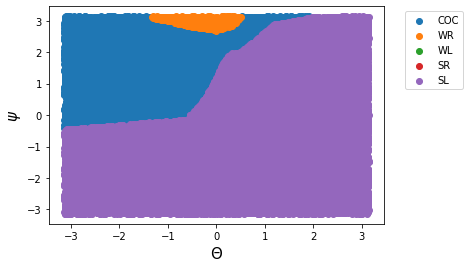

In [279]:
clustering_attempt(50000, 1, 2)

In [280]:
max_values = [np.max(rand_outputs[:, i]) for i in range(5)]
min_values = [np.min(rand_outputs[:, i]) for i in range(5)]
mean_values = [np.mean(rand_outputs[:, i]) for i in range(5)]
p5 = [np.percentile(rand_outputs[:, i], 5) for i in range(5)]
p95 = [np.percentile(rand_outputs[:, i], 95) for i in range(5)]
print("Maxima: ", max_values)
print("Minima: ", min_values)
print("Mean values: ", mean_values)
print("5th percentile: ", p5)
print("95th percentile", p95)

Maxima:  [0.013805518, 0.019990219, 0.13644679, 0.9996823, 0.90597504]
Minima:  [1.2702534e-07, 0.0003105947, 7.0034184e-06, 0.019823257, 7.500304e-09]
Mean values:  [0.0009061997, 0.0041305344, 0.00979491, 0.96959287, 0.015575443]
5th percentile:  [2.3502485007043104e-07, 0.0004058257371070795, 1.1069022775700432e-05, 0.8783774644136428, 1.6267562141791813e-08]
95th percentile [0.004933892749249934, 0.015583826228976244, 0.056247988529503246, 0.9995826721191406, 0.04331267084926361]
